In [1]:
project_name = 'inno_hack'

In [2]:
import numpy as np
import pandas as pd
import sklearn
from importlib import reload
import sys
from os import path

sys.path.append('/home/greg/Personal/hackaton/rolling_drones_1/custom_modules')
import my_sklearn_transformers as trsfm
reload(trsfm)

pd.set_option('display.max_columns', 500)
path_to_data_dir = lambda x: path.join('/home/greg/Personal/hackaton/rolling_drones_1/ml/', *(x if isinstance(x, str) is False else [x]))
path_to_cp_dir = lambda x: path.join('/home/greg/Personal/hackaton/rolling_drones_1/models/', *(x if isinstance(x, str) is False else [x]))
path_to_pipeline_dir = lambda x: path.join('/home/greg/Personal/hackaton/rolling_drones_1/pipelines/', *(x if isinstance(x, str) is False else [x]))

In [3]:
U = pd.read_csv(path_to_data_dir('company_and_its_investor.csv'))

In [4]:
U.head(3)

,Unnamed: 0,inn__investor,name__investor,type__investor,description__investor,startup_stage__investor,market__investor,services__investor,technologies__investor,type_of_ownership__investor,investment_round__investor,investition_from_dol__investor,investition_to_dol__investor,tech_focus__investor,fund_total_rub__investor,fund_total_dol__investor,num_of_investments__investor,num_of_exits__investor,market_non_focus__investor,startup_stage_non_focus__investor,tech_focus_non_focus__investor,technologies_non_focus__investor,geography__investor,study_format__investor,num_of_people_in_company_from__investor,num_of_people_in_company_to__investor,num_of_participants__investor,okved_main__investor,okved_secondary__investor,corp_stage__investor,business_model__investor,monetary_support__investor,inn__company,name__company,got_support_from__company,did_get_support__company,service__company,foundation_date__company,tech_focus__company,stage_of_development__company,market__company,technology__company,business_model__company,main_okved__company,okved_secondary__company,msp_category__company,is_export__company,inno_cluster_member__company,skolcovo_member__company,is_inno_company__company,is_startup__company,current_profit__company,current_profit_tax__company,current_revenue__company,type__company
0,0,7703638456,da vinci capital,VentureFund,"компания по управлению активами, специализирую...","['ранний рост', 'расширение']","['cybersecurity', 'transport & logistics', 'bu...",['инвестиции'],"['ar/vr', 'big data', 'блокчейн', 'интернет ве...",частный,"['раунд а', 'раунд в', 'раунд с+']",1000000.0,50000000.0,[],25000.0,397.0,17.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7704794345,"ооо ""геттакси рус""",карта инновационных решений,да,добавлено - карта инновационных решений,2011-11-03,['транспорт и логистика'],расширение,['transport & logistics'],[],['b2c'],62.09,"['82.99', '46.19', '63.11', '47.91', '69.20', ...",NaN,нет,да,нет,да,нет,-23.0,-15.0,1507.0,Company
1,1,7728461088,new industry ventures,VentureFund,"совместный фонд “газпром нефти”, газпромбанка,...","['ранний рост', 'расширение', 'посевная']",['cleantech'],['инвестиции'],"['3d моделирование', 'big data', 'интернет вещ...",частный,"['seed', 'раунд а', 'раунд в']",500000.0,3000000.0,[],4000.0,62.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7714762021,"ооо ""скайер ит""",московский акселератор,нет,московский акселератор,2008-12-23,['недвижимость и строительство'],ранний рост,['proptech'],['беспилотники'],['b2b'],72.19,"['62.09', '85.42', '62.02', '63.11', '30.30', ...",юл микро,нет,да,да,да,нет,-16450.0,0.0,19127.0,Company
2,2,7728461088,new industry ventures,VentureFund,"совместный фонд “газпром нефти”, газпромбанка,...","['ранний рост', 'расширение', 'посевная']",['cleantech'],['инвестиции'],"['3d моделирование', 'big data', 'интернет вещ...",частный,"['seed', 'раунд а', 'раунд в']",500000.0,3000000.0,[],4000.0,62.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7714762021,"ооо ""радуга""",карта инновационных решений,да,добавлено - карта инновационных решений,2008-12-23,['недвижимость и строительство'],ранний рост,['proptech'],['беспилотники'],['b2b'],72.19,"['62.09', '85.42', '62.02', '63.11', '30.30', ...",юл микро,нет,да,да,да,нет,-16450.0,0.0,19127.0,Company


In [5]:
import ast
def try_load_list(val):
    try:
        res = ast.literal_eval(val)
        if isinstance(res, list):
            return res
        else:
            return []
    except Exception as e:
        return []

In [6]:
import tweaks
reload(trsfm)

<module 'my_sklearn_transformers' from '/home/greg/Personal/hackaton/rolling_drones_1/ml/my_sklearn_transformers.py'>

In [7]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer

onehot_company = ['stage_of_development__company', 'main_okved__company', 'msp_category__company', 'is_export__company', 'inno_cluster_member__company', 'skolcovo_member__company',
                  'is_inno_company__company', 'is_startup__company']
multilabel_company = ['tech_focus__company', 'market__company', 'technology__company', 'business_model__company', 'okved_secondary__company']

num_investor = ['investition_from_dol__investor', 'investition_to_dol__investor', 'fund_total_rub__investor', 
                'fund_total_dol__investor', 'num_of_investments__investor', 'num_of_exits__investor']
onehot_investor = ['type_of_ownership__investor']
multilabel_investor = ['startup_stage__investor', 'market__investor', 'services__investor', 'technologies__investor', 'investment_round__investor', 'tech_focus__investor']

def map_lists(x):
    return np.array([try_load_list(i) for i in x], dtype=object)

preprocessor_X = make_union(
    make_pipeline(
        trsfm.DfSelector(onehot_company),
        SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=''),
        OneHotEncoder(sparse=False, handle_unknown='ignore'),
    ),
    *([make_pipeline(
        trsfm.DfSelector([col]),
        FunctionTransformer(np.reshape, kw_args={'newshape': (-1, )}),
        FunctionTransformer(tweaks.map_lists),
        # FunctionTransformer(print),
        trsfm.MultilabelEncoder(),
        trsfm.MemorizeOutShape()
    ) for col in multilabel_company])
)

preprocessor_Y = make_union(
    make_pipeline(
        trsfm.DfSelector(onehot_investor),
        SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=''),
        OneHotEncoder(sparse=False, handle_unknown='ignore'),
    ),
    make_pipeline(
        trsfm.DfSelector(num_investor),
        SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
        MinMaxScaler(),
    ),
    *([make_pipeline(
        trsfm.DfSelector([col]),
        FunctionTransformer(np.reshape, kw_args={'newshape': (-1, )}),
        FunctionTransformer(tweaks.map_lists),
        trsfm.MultilabelEncoder(),
        trsfm.MemorizeOutShape()
    ) for col in multilabel_investor])
)

In [8]:
investor_metrics = onehot_investor + num_investor + multilabel_investor

In [9]:
# for t in preprocessor_X.transformer_list:
#     print(t[1].n_features_in_,
#             t[1][-1].n_features_
#             )

In [45]:
def get_out_features(transformer):
    if hasattr(transformer, 'n_features_'):
        return [transformer.n_features_]
    elif hasattr(transformer, 'categories_'):
        return [len(x) for x in transformer.categories_]
    else:
        return [1]

coords_lens = np.concatenate([get_out_features(t[1][-1]) for t in preprocessor_X.transformer_list])
coords_lens

array([  4,  26,   5,   3,   3,   3,   3,   3,  21,  25,  12,   5, 291])

In [11]:
# preprocessor_X.transformer_list[0][1]

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for train, test in sss.split(U, U['type_of_ownership__investor'].fillna('')):
    train_idx, test_idx = train, test

In [13]:
X_tr = preprocessor_X.fit_transform(U.iloc[train_idx])
X_te = preprocessor_X.transform(U.iloc[test_idx])
y_tr = preprocessor_Y.fit_transform(U.iloc[train_idx])
y_te = preprocessor_Y.transform(U.iloc[test_idx])

WARN: MultilabelEncoder takes only one col at a time! Given  (41, 0)


In [14]:
from joblib import dump

dump(preprocessor_X, path_to_pipeline_dir('fund_classifier_preprocessor_X.joblib'))
dump(preprocessor_Y, path_to_pipeline_dir('fund_classifier_preprocessor_Y.joblib'))

['/home/greg/Personal/hackaton/rolling_drones_1/pipelines/fund_classifier_preprocessor_Y.joblib']

In [15]:
unique_fund = U.drop_duplicates(subset=['name__investor'])
investors_space = preprocessor_Y.transform(unique_fund)
investors_space_name = unique_fund['name__investor'].values
fund_name_te = U.iloc[test_idx]['name__investor'].values

In [16]:
investors_space.shape

(59, 78)

In [17]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape, y_tr.min(), y_tr.max()

((362, 404), (41, 404), (362, 78), (41, 78), 0.0, 1.0)

# Модель

Генерация предсказания построена так:
Данные о компании, для которой нужно получить рекомендацию, переводяться в n-мерный вектор, который при помощи 2-слойной модели проецируется в m-мерное пространство сервисов. Далее сравнивается L2 норм расстояния от проекции вектора компании до векторов сервисов, и по данным расстояниям сервисы сортируются в порядке убывания релевантности.  

In [68]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError

es_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=200, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

loss = MeanSquaredError()

l_size = 64
dropo = 0.5

model = tf.keras.Sequential(layers=[
    layers.Dense(l_size, input_shape=(X_tr.shape[1],), activation='sigmoid'),
    layers.Dropout(dropo),
    layers.Dense(y_tr.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss=loss)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                25920     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 78)                5070      
Total params: 30,990
Trainable params: 30,990
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(X_tr, y_tr, validation_data=(X_te, y_te), epochs=3000, callbacks=[es_cb])

Epoch 1/3000
12/12 [==============================] - 0s 24ms/step - loss: 0.2570 - val_loss: 0.2222
Epoch 2/3000
12/12 [==============================] - 0s 7ms/step - loss: 0.2199 - val_loss: 0.1956
Epoch 3/3000
12/12 [==============================] - 0s 11ms/step - loss: 0.1982 - val_loss: 0.1815
Epoch 4/3000
12/12 [==============================] - 0s 13ms/step - loss: 0.1857 - val_loss: 0.1747
Epoch 5/3000
12/12 [==============================] - 0s 13ms/step - loss: 0.1789 - val_loss: 0.1711
Epoch 6/3000
12/12 [==============================] - 0s 12ms/step - loss: 0.1744 - val_loss: 0.1691
Epoch 7/3000
12/12 [==============================] - 0s 9ms/step - loss: 0.1732 - val_loss: 0.1678
Epoch 8/3000
12/12 [==============================] - 0s 9ms/step - loss: 0.1709 - val_loss: 0.1670
Epoch 9/3000
12/12 [==============================] - 0s 8ms/step - loss: 0.1688 - val_loss: 0.1661
Epoch 10/3000
12/12 [==============================] - 0s 10ms/step - loss: 0.1667 - val_loss: 

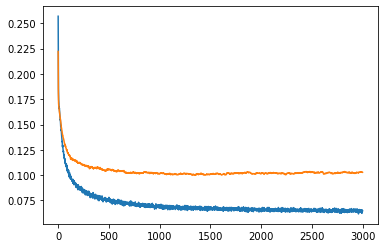

In [71]:
import matplotlib.pyplot as plt

plt.plot(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss']);

In [75]:
model.save(path_to_cp_dir('model_fund_classifier.h5'))

In [33]:
tf.__version__

'2.2.0'

In [72]:
coords_lens

array([  4,  26,   5,   3,   3,   3,   3,   3,  21,  25,  12,   5, 291])

In [73]:
from numpy import linalg as LA

take_n_first = 3
preds = model.predict(X_te)

right_count = 0
for i in range(len(preds)):
    err = investors_space - preds[i]
    distance_by_coords = np.array([[np.mean((x[coords_lens[i - 1: i]]) ** 2) for i in range(1, len(coords_lens))] for x in err])
    metric_imp_sorted = np.argsort(distance_by_coords, axis=1)
    idx_sorted = np.argsort(np.apply_along_axis(LA.norm, 1, err, ord=2))
    print("Pred={}, y={}, dist={}".format(investors_space_name[idx_sorted[:take_n_first]], fund_name_te[i], np.apply_along_axis(lambda x: [investor_metrics[i] for i in x], 1, metric_imp_sorted[:take_n_first, :3])))
    if fund_name_te[i] in investors_space_name[idx_sorted[:take_n_first]]:
        right_count += 1

Pred=['фрии' 'the untitled ventures' 'leta capital'], y=фрии, dist=[['services__investor' 'fund_total_rub__investor'
  'fund_total_dol__investor']
 ['technologies__investor' 'fund_total_rub__investor'
  'fund_total_dol__investor']
 ['fund_total_rub__investor' 'fund_total_dol__investor'
  'num_of_investments__inve']]
Pred=['фрии' 'the untitled ventures' 'leta capital'], y=фрии, dist=[['services__investor' 'fund_total_rub__investor'
  'fund_total_dol__investor']
 ['technologies__investor' 'fund_total_rub__investor'
  'fund_total_dol__investor']
 ['fund_total_rub__investor' 'fund_total_dol__investor'
  'num_of_investments__inve']]
Pred=['фрии' 'leta capital' 'da vinci capital'], y=дальневосточный фонд высоких технологий, dist=[['type_of_ownership__investor' 'investition_to_dol__investor'
  'investment_round__investor']
 ['type_of_ownership__investor' 'investition_to_dol__investor'
  'investment_round__investor']
 ['investition_to_dol__investor' 'investment_round__investor'
  'type_of_owne

In [74]:
right_count / len(preds)

0.5609756097560976